In [44]:
import findspark
findspark.init()

In [61]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext,SparkSession
from pyspark.sql.types import *
from pyspark.rdd import RDD
from branca.colormap import linear
import folium
import folium.plugins
from folium import features
import ipywidgets as widgets
import ipywidgets as wg
from ipywidgets import Button, HBox, VBox
from IPython.display import display,clear_output,IFrame
from itertools import islice
from googlesearch import *
import numpy as np
import webbrowser
import json
import os
import re
import csv
import dask.dataframe
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.text import Text
from matplotlib.image import AxesImage
import numpy as np
from numpy.random import rand
import decimal
%matplotlib inline

In [46]:
conf = SparkConf().setAppName('USA-app').setMaster('local')
sc = SparkContext.getOrCreate(conf=conf)
sqlc = SQLContext(sc)

spark = SparkSession \
    .builder \
    .appName("USA accidents mining") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
info = json.load(open("json/accidents-info.json"))

accidents = spark.read.csv("csv/US_Accidents_May19.csv",header=True,sep = ',');
accidents.createOrReplaceTempView("accidents")
result = spark.sql("select * from accidents ")

def tabellen():
    def f(x):    
        if x == 1:
            return result.select("ID","Source","TMC","Severity","Start_Time","End_Time","Start_Lat","Start_Lng").show(20)
        elif x == 2:
            return result.select("ID","Description").show(20,False)  
        elif x == 3:
            return result.select("ID","Distance(mi)","Number","Street","Side","City","County","State","Zipcode","Country","Timezone").show(21)
        elif x == 4:
            return result.select("ID","Airport_code","Weather_Timestamp","Temperature(F)","Wind_Chill(F)","Humidity(%)","Pressure(in)").show(20)
        elif x == 5:
            return result.select("ID","Visibility(mi)","Wind_Direction","Wind_Speed(mph)","Precipitation(in)","Weather_Condition").show(20)
        elif x == 6:
            return result.select("ID","Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway","Roundabout").show(20)
        elif x == 7:
            return result.select("ID","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop").show(20)
        elif x == 8:
            return result.select("ID","Sunrise_Sunset","Civil_Twilight","Nautical_Twilight","Astronomical_Twilight").show(20)
        else:
            return print("error in selectie van tabel")

    wg.interact(f, x=wg.IntSlider(min=1,max=8,step=1));

In [40]:
text = widgets.Text()
code_text = widgets.Text()

def handle_submit_headers_json(sender):
    for i in info:
        if text.value == i or text.value.lower() in str(i).lower(): 
            print(info[i]["explanation"])
            result.select(i).show(10)
    if text.value == "TMC" or text.value == "tmc" :
        [print("code: " + i,end=' ') for i in info["TMC"]["codes"]] 
        display(code_text)

In [41]:
def handle_submit_tmc(sender):
    for i in info["TMC"]["codes"]:
        if code_text.value == i:
            print(info["TMC"]["codes"][i])

In [58]:
out1 = widgets.Output()
out2 = widgets.Output()
out3 = widgets.Output()

tab = widgets.Tab(children = [out1, out2,out3])
tab.set_title(0, 'tables')
tab.set_title(1, 'search info header')
tab.set_title(2, 'google search')
display(tab)

with out1:
    tabellen()
        
with out2:
    text.on_submit(handle_submit_headers_json)
    code_text.on_submit(handle_submit_tmc) 
    display(text)
    
with out3:
    googletext = widgets.Text()

    def handle_submit_google(sender):
        for url in search(googletext.value, tld="co.in", num=1, stop = 1, pause = 2):
            display(IFrame(src="https://www.google.com/search?igu=1&ei=&q=%s" % googletext.value, width='100%', height='500px'))

    googletext.on_submit(handle_submit_google)
    display(googletext)

In [8]:
def getJsonFromAccidentFile(take, *cols):
    if cols[0] == -1:
        sqllatlng = result.select("*").dropna().rdd.map(lambda r: r).take(take)
    elif cols[0] == -2:
        whereState = cols[1]
        colArr = []
        for col in cols:
            colArr.append(col)
        colArr.pop(0)
        colArr.pop(0)
        sqllatlng = result.select(colArr).where(whereState).dropna().rdd.map(lambda r: r).take(take)
    else:
        colArr = []
        for col in cols:
            colArr.append(col)
        sqllatlng = result.select(colArr).dropna().rdd.map(lambda r: r).take(take)
    
    jsonlatlng = json.dumps(sqllatlng)
    load = json.loads(jsonlatlng)
    return load

In [9]:
def getJsonFromHolidaysFile(take, all, *cols):
    accidents = spark.read.csv("csv/usholidays.csv",header=True,sep = ',');
    accidents.createOrReplaceTempView("holidays")
    holidaysTable = spark.sql("select * from holidays ")
    
    if(all):
        if(take>0):
            sqllatlng = holidaysTable.map(lambda r: r).take(take)
        else:
            sqllatlng = holidaysTable.map(lambda r: r).collect()
    else:
        colArr = []
        for col in cols:
            colArr.append(col)
        
        if(take>0):
            sqllatlng = holidaysTable.select(colArr).dropna().rdd.map(lambda r: r).take(take)
        else:
            sqllatlng = holidaysTable.select(colArr).dropna().rdd.map(lambda r: r).collect()

    jsonlatlng = json.dumps(sqllatlng)
    load = json.loads(jsonlatlng)
    return load

In [10]:
all = getJsonFromAccidentFile(100000000, "Start_Time")

In [11]:
def getAccidentHolidays():
    holidays = getJsonFromHolidaysFile(-1, False, "date", "holiday")
    holidays = list(filter( lambda x: (int(x[0][0:4]) > 2016 | (int(x[0][0:4]) == 2016 & int(x[0][5:6]) > 2)), holidays))
    holidays = list(filter( lambda x: (int(x[0][0:4]) < 2019 | (int(x[0][0:4]) == 2019 & int(x[0][5:6]) < 5)), holidays))
    
    holidaysAccident = []
    for holiday in holidays:
        ha = {}
        ha["date"] = holiday[0]
        ha["name"] = holiday[1]
        ha["accidents"] = sum(holiday[0] in y[0] for y in all)
        holidaysAccident.append(ha)
        
        dateCheck = holiday[0]
    return holidaysAccident
list_accidents_holidays = getAccidentHolidays()

In [12]:
def getAccidentDate(datum, holiday=""):
    acc = []

    iDatum = datetime.strptime(datum, "%Y-%m-%d") + timedelta(days=-7)
    i=-7
    while(i <= 7):
        iDatumStr = iDatum.strftime('%Y-%m-%d')
        ha = {}
        ha["date"] = iDatumStr
        if(iDatumStr == datum):
            ha["date"] = ha['date'] + " - " + holiday
        ha["accidents"] = sum(iDatumStr in y[0] for y in all)
        acc.append(ha)
        iDatum = iDatum + timedelta(days=1)
        i=i+1
        
    return acc
getAccidentDate('2016-12-20')

[{'date': '2016-12-13', 'accidents': 2658},
 {'date': '2016-12-14', 'accidents': 2675},
 {'date': '2016-12-15', 'accidents': 2874},
 {'date': '2016-12-16', 'accidents': 3264},
 {'date': '2016-12-17', 'accidents': 903},
 {'date': '2016-12-18', 'accidents': 755},
 {'date': '2016-12-19', 'accidents': 2553},
 {'date': '2016-12-20 - ', 'accidents': 2625},
 {'date': '2016-12-21', 'accidents': 2337},
 {'date': '2016-12-22', 'accidents': 2586},
 {'date': '2016-12-23', 'accidents': 2376},
 {'date': '2016-12-24', 'accidents': 600},
 {'date': '2016-12-25', 'accidents': 425},
 {'date': '2016-12-26', 'accidents': 575},
 {'date': '2016-12-27', 'accidents': 1751}]

In [13]:
def getLists(listFrom, listToX, listToY):
    listOutX = []
    listOutY = []
    for name in listFrom:
        listOutX.append(name[listToX])
        listOutY.append(name[listToY])
    listOut = [listOutX, listOutY]
    return listOut

<IPython.core.display.Javascript object>


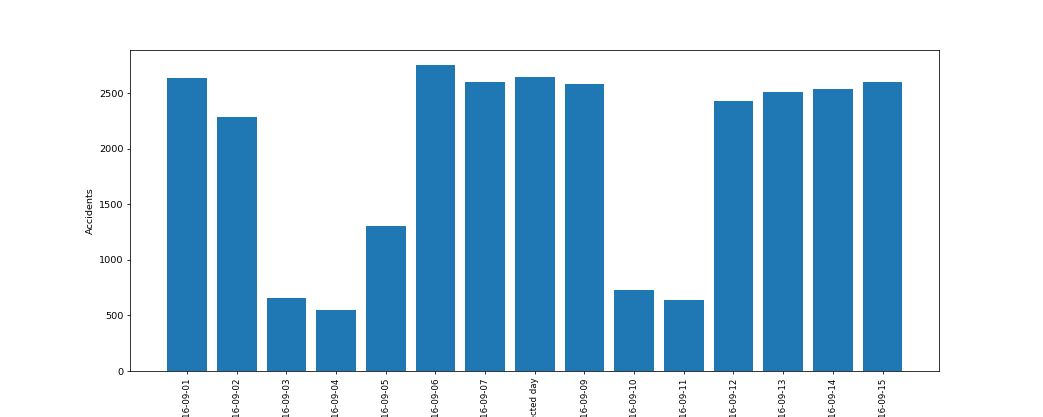

In [49]:
def createTableDate(datum, holiday=''):
    dataLists = getLists(getAccidentDate(datum, holiday), 'date', 'accidents')
    
    figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.bar(dataLists[0], dataLists[1])
    plt.xlabel('Date')
    plt.xticks(fontsize=9)
    plt.xticks(rotation=90)
    plt.ylabel('Accidents')
    return plt
tableDateTrial = createTableDate('2016-09-08', 'selected day')

In [33]:
names = []
accidents = []
dates = []
for name in list_accidents_holidays:
    current: str
    
    if name["name"] == "Birthday of Martin Luther King, Jr.":
        current = "MLK Bday"
    elif name["name"] == "Thanksgiving Day":
        current = "Thanksgiving"
    elif name["name"] == "New Year's Day":
        current = "New Year"
    elif name["name"] == "Christmas Day":
        current = "Christmas"
    elif name["name"] == "Washington's Birthday":
        current = "Washington Bday"
    else:
        current = name["name"]
                
    names.append(current + " - " + name["date"][:4])
        
    accidents.append(name["accidents"])
    
    dates.append(name["date"])

<IPython.core.display.Javascript object>


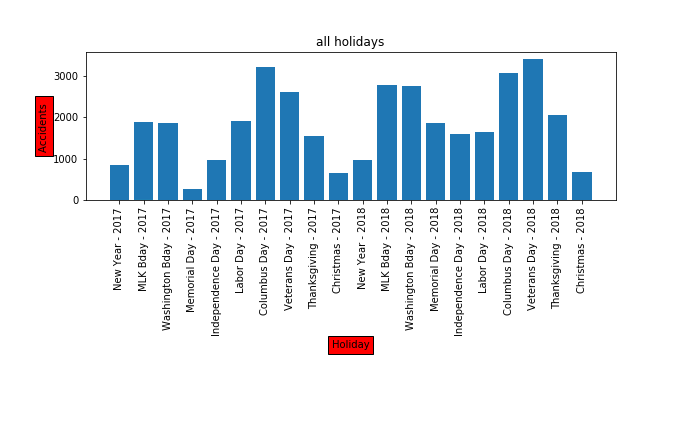

7

In [65]:
%matplotlib notebook
fig, ( ax2, ax1) = plt.subplots(2, 1)
fig.set_size_inches(9.5, 6)
ax1.set_visible(False)
ax2.set_ylabel('Accidents ', picker=True, bbox=dict(facecolor='red'))
ax2.set_xlabel('Holiday', picker=True, bbox=dict(facecolor='red'))

ax2.bar(names, accidents, picker=True)

for i in range(len(names)):
    ax2.bar(1, i, align='center', bottom=bottom, alpha=0.5, label=dates[i][0:10], picker=4)

for label in ax2.get_xticklabels():
    label.set_picker(True)
    label.set_rotation(90)


ax2.set_title('all holidays')

def onpick1(event):    
    ax = fig.add_subplot(212)

    ax.set_visible(True)
     
    line = event.artist
    index_clicked = int(line.xy[0] + 0.4)
    found_date = dates[index_clicked][0:10]
    dataLists = getLists(getAccidentDate(found_date, names[index_clicked]), 'date', 'accidents')

    ax.bar(dataLists[0], dataLists[1])
    
    ax.set_xlabel("dates", picker=True, bbox=dict(facecolor='red'))
    ax.set_ylabel("exidents", picker=True, bbox=dict(facecolor='red'))
    old_title = ax.get_title()
    if(old_title == ''):
        ax.set_title(names[index_clicked])
    else:
        ax.set_title(old_title + ' + ' + names[index_clicked])
    
    plt.xticks(rotation=90)
    plt.subplots_adjust(hspace=2.5)
    plt.draw()


fig.canvas.mpl_connect('pick_event', onpick1)

Text(0, 0.5, 'Accidents')

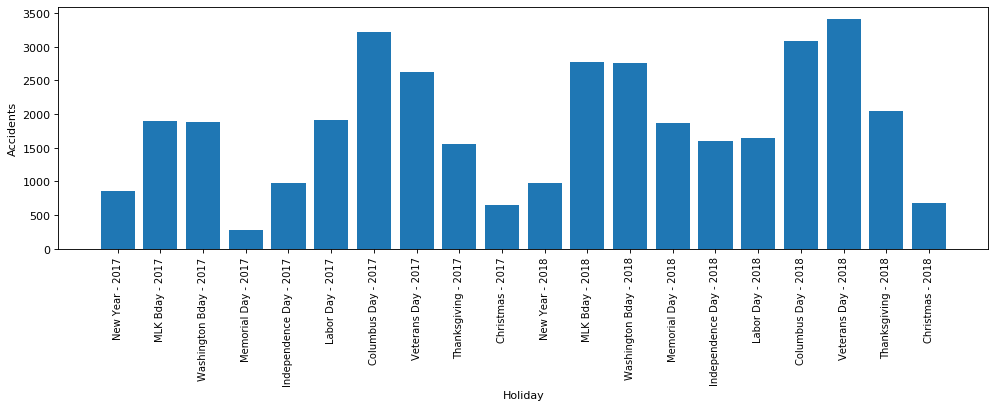

In [66]:
%matplotlib inline
figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
plt.bar(names, accidents)
plt.xlabel('Holiday')
plt.xticks(fontsize=9)
plt.xticks(rotation=90)
plt.ylabel('Accidents')

Text(value='day')

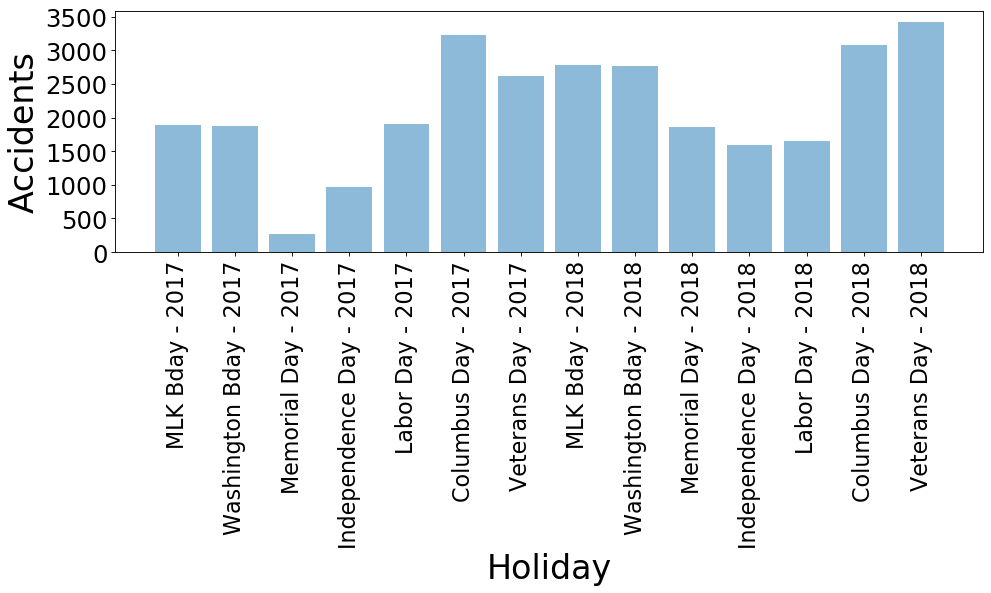

In [62]:
inputPartOfHolidayNames = widgets.Text()

def show_graph_specific_holidays(sender):
    specific_name = []
    specific_accidents = []
    clear_output()
    display(inputPartOfHolidayNames)
    for naam in names:
        if inputPartOfHolidayNames.value.lower() in naam[:-4].lower():
            specific_name.append(naam)
            specific_accidents.append(accidents[names.index(naam)])
    figure(num=None, figsize=(len(specific_name), 4), dpi=80, facecolor='w', edgecolor='k')
    
    #for naam in specific_name:
    plt.bar(specific_name,specific_accidents, alpha=0.5)
    plt.xlabel('Holiday', fontsize=30)
    plt.xticks(rotation=90, fontsize=20)
    plt.yticks(fontsize=22)
    plt.ylabel('Accidents', fontsize=30)

inputPartOfHolidayNames.on_submit(show_graph_specific_holidays)
inputPartOfHolidayNames

In [22]:
textfield_folium = widgets.Text()
cijfer = ""
load = ""
kkkkkkkk = ""
def handle_submit_folium(sender):
    cijfer = textfield_folium.value
    sqllatlng = result.select("ID","Start_Lat","Start_Lng", "Temperature(F)", "Description").dropna().rdd.map(lambda r: r).takeSample(False,int(cijfer))
    jsonlatlng = json.dumps(sqllatlng)
    load = json.loads(jsonlatlng)

    m = folium.Map(location=[0, 0],zoom_start=2 )
    cluster = folium.plugins.MarkerCluster().add_to(m)
    tile = ['Mapbox Bright', 'Mapbox Control Room','stamenwatercolor','OpenStreetMap']
    tooltip = "click here please!"

    for t in tile:
        folium.TileLayer(t).add_to(m)


    nieuwelijst = []
    for w in load:
        
        Fahrenheit = float(w[3])
        Celsius = (Fahrenheit - 32) * 5.0/9.0
        
        folium.Marker(location = [w[1],w[2]], popup='<i>'+ w[4] +'</i>', tooltip=str("%.2f" % Celsius)+'°C').add_to(cluster)
        kkkkkkkk = w



    folium.LayerControl(collapsed=True).add_to(m)
    clear_output()
    display(textfield_folium)
    display(m)
    
    
textfield_folium.on_submit(handle_submit_folium)
kkkkkkkk
textfield_folium

Text(value='1000')